In [1]:
import numpy as np
from tqdm import tqdm
import math
from sklearn import preprocessing

In [2]:
def shuffle(x, y):
    idx = [i for i in range(x.shape[0])]
    np.random.shuffle(idx)
    return x[idx,:], y[idx]

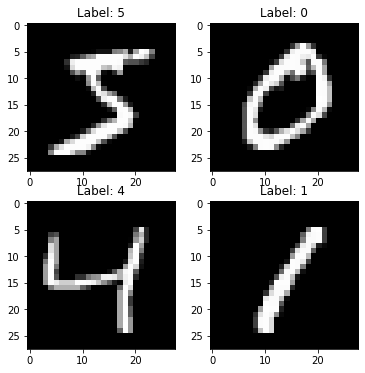

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

from mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

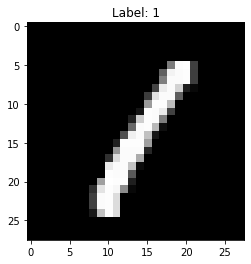

In [4]:
plt.title("Label: %i"%y_train[3])
plt.imshow(X_train[3].reshape([28,28]),cmap='gray')

In [5]:
import math
np.random.seed(0)
def xavier_init(x_in, x_out):
    scale = 1/max(1., (x_in+x_out)/2.)
    weights = np.sqrt(scale)*np.random.randn(x_in,x_out)
    return weights

In [6]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    if np.isinf(xentropy).any():
        return 10*np.ones((xentropy.shape[0],))
    else:
        return xentropy
    
    

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

# SGD

In [8]:
class Custom_NN:
    
    def __init__(self, batch, lr, epochs):
        
        self.batch = batch
        self.epochs = epochs
        self.lr = lr
        
    def init_weights(self, X):
        
        self.w1 = np.random.uniform(-0.99,0.99, size=(X.shape[1],128))
        self.w2  =   np.random.uniform(-0.99,0.99, size=(self.w1.shape[1], 10)) 
        
        self.b1 = np.random.uniform(-0.99,0.99, size=(self.w1.shape[1], 1))
        self.b2  =   np.random.uniform(-0.99,0.99, size=(self.w2.shape[1], 1)) 

        
    def forward(self, X):
            
        self.z1 = X.dot(self.w1)+self.b1.T 
        self.y1 = self.sigmoid(self.z1)
        
        self.z2 = self.y1.dot(self.w2)+self.b2.T
        
    def backward(self, X, y):
        
        self.loss = softmax_crossentropy_with_logits(self.z2, y)
        
        grad2_1_w = self.loss 
        grad2_2_w = grad_softmax_crossentropy_with_logits(self.z2, y)  
        grad2_3_w = self.y1 

        grad2_w = grad2_3_w.T.dot(grad2_1_w.reshape(-1,1) * grad2_2_w)
        grad2_b = np.sum(grad2_1_w.reshape(-1,1) * grad2_2_w)
        
        
        grad1_1_w = (grad2_1_w.reshape(-1,1) * grad2_2_w).dot(self.w2.T)
        grad1_2_w = self.sigmoid_grad(self.z1)
        grad1_3_w = X
        
        grad1_w = grad1_3_w.T.dot(grad1_1_w * grad1_2_w) 
        grad1_b = np.sum(grad1_1_w * grad1_2_w) 
       
        
        self.w2 = self.w2 - self.lr * grad2_w
        self.w1 = self.w1 - self.lr * grad1_w
        
        self.b2 = self.b2 - self.lr * grad2_b
        self.b1 = self.b1 - self.lr * grad1_b
    
    
    def fit(self, X, y):
        
        self.init_weights(X)
        self.loss_total = []
        for epoch in tqdm(range(self.epochs)):
            loss = 0
            x_tr, y_tr = self.shuffle(X, y)
            for batch in range(x_tr.shape[0]//self.batch-1):
                start = batch * self.batch
                end = (batch+1) * self.batch
                self.forward(X = x_tr[start:end])
                self.backward(X = x_tr[start:end], y = y_tr[start:end])
                loss += self.loss
        
            loss_mean = np.mean(loss/(x_tr.shape[0]//self.batch))

            self.loss_total.append(loss_mean)
            
    def predict(self, X):
        
        self.forward(X)
    
        return list(map(lambda x : x.argmax(), self.z2))
        
    
    def relu(self,x):
            
        return np.maximum(0,x)
        
    def relu_grad(self,x):
            
        return (x>0)*1
    
    def linear(self,x):
        
        return x
    
    def linear_grad(self,x):
        
        return np.sign(x)
    
    def sigmoid(self,x):
        
        return 1./(1+np.exp(-x))
    
    def sigmoid_grad(self,x):
        
        return (np.exp(-x))/(1+np.exp(-x))**2
        f
        
    def shuffle(self, x, y):
        idx = [i for i in range(x.shape[0])]
        np.random.shuffle(idx)
        return x[idx], y[idx]
        
        

In [9]:
nn = Custom_NN(batch = 512, lr = 1e-2, epochs = 40)

In [10]:
nn.fit(X_train, y_train)

100%|███████████████████████████████████████████| 40/40 [00:33<00:00,  1.21it/s]


In [11]:
predicted = nn.predict(X_test)

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, predicted, target_names= ['0','1','2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89       980
           1       0.93      0.93      0.93      1135
           2       0.79      0.78      0.79      1032
           3       0.78      0.80      0.79      1010
           4       0.81      0.80      0.80       982
           5       0.73      0.73      0.73       892
           6       0.88      0.86      0.87       958
           7       0.85      0.83      0.84      1028
           8       0.74      0.75      0.74       974
           9       0.74      0.77      0.76      1009

    accuracy                           0.82     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.82      0.82      0.82     10000



In [13]:
loss_simple_sgd = nn.loss_total

# Momentum

In [14]:
class Custom_NN:
    
    def __init__(self, batch, lr, epochs, v1 = 0, v2 = 0, v3 = 0, v4 = 0):
        
        self.batch = batch
        self.epochs = epochs
        self.lr = lr
        self.v1_w = v1
        self.v2_w = v2
        self.v1_b = v3
        self.v2_b = v4
        
        
    def init_weights(self, X):
        
        self.w1 = np.random.uniform(-0.99,0.99, size=(X.shape[1],128))
        self.w2  =   np.random.uniform(-0.99,0.99, size=(self.w1.shape[1], 10)) 
        
        self.b1 = np.random.uniform(-0.99,0.99, size=(self.w1.shape[1], 1))
        self.b2  =   np.random.uniform(-0.99,0.99, size=(self.w2.shape[1], 1)) 

        
    def forward(self, X):
            
        self.z1 = X.dot(self.w1)+self.b1.T 
        self.y1 = self.sigmoid(self.z1)
        
        self.z2 = self.y1.dot(self.w2)+self.b2.T
        
    def backward(self, X, y):
        
        self.loss = softmax_crossentropy_with_logits(self.z2, y)
        
        grad2_1_w = self.loss 
        grad2_2_w = grad_softmax_crossentropy_with_logits(self.z2, y)  
        grad2_3_w = self.y1 

        grad2_w = grad2_3_w.T.dot(grad2_1_w.reshape(-1,1) * grad2_2_w)
        grad2_b = np.sum(grad2_1_w.reshape(-1,1) * grad2_2_w)
        
        
        grad1_1_w = (grad2_1_w.reshape(-1,1) * grad2_2_w).dot(self.w2.T)
        grad1_2_w = self.sigmoid_grad(self.z1)
        grad1_3_w = X
        
        grad1_w = grad1_3_w.T.dot(grad1_1_w * grad1_2_w) 
        grad1_b = np.sum(grad1_1_w * grad1_2_w) 
        
        
        
        self.v2_w = self.v2_w * 0.9 + self.lr * grad2_w
        self.v1_w = self.v1_w * 0.9 + self.lr * grad1_w
        
        self.v2_b = self.v2_b * 0.9 + self.lr * grad2_b
        self.v1_b = self.v1_b * 0.9 + self.lr * grad1_b
        
        self.w2 = self.w2 - self.v2_w
        self.w1 = self.w1 - self.v1_w
        
        self.b2 = self.b2 - self.v2_b
        self.b1 = self.b1 - self.v1_b
    
    
    def fit(self, X, y):
        
        self.init_weights(X)
        self.loss_total = []
        for epoch in tqdm(range(self.epochs)):
            loss = 0
            x_tr, y_tr = self.shuffle(X, y)
            for batch in range(x_tr.shape[0]//self.batch-1):
                start = batch * self.batch
                end = (batch+1) * self.batch
                self.forward(X = x_tr[start:end])
                self.backward(X = x_tr[start:end], y = y_tr[start:end])
                loss += self.loss
        
            loss_mean = np.mean(loss/(x_tr.shape[0]//self.batch))

            self.loss_total.append(loss_mean)
            
    def predict(self, X):
        
        self.forward(X)
    
        return list(map(lambda x : x.argmax(), self.z2))
        
    
    def relu(self,x):
            
        return np.maximum(0,x)
        
    def relu_grad(self,x):
            
        return (x>0)*1
    
    def linear(self,x):
        
        return x
    
    def linear_grad(self,x):
        
        return np.sign(x)
    
    def sigmoid(self,x):
        
        return 1./(1+np.exp(-x))
    
    def sigmoid_grad(self,x):
        
        return (np.exp(-x))/(1+np.exp(-x))**2
        
        
    def shuffle(self, x, y):
        idx = [i for i in range(x.shape[0])]
        np.random.shuffle(idx)
        return x[idx], y[idx]
        
        

In [15]:
nn = Custom_NN(batch = 512, lr = 1e-2, epochs = 40)

In [16]:
nn.fit(X_train, y_train)
predicted = nn.predict(X_test)

100%|███████████████████████████████████████████| 40/40 [00:34<00:00,  1.16it/s]


In [17]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, predicted, target_names= ['0','1','2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       980
           1       0.97      0.98      0.97      1135
           2       0.91      0.89      0.90      1032
           3       0.89      0.90      0.89      1010
           4       0.90      0.92      0.91       982
           5       0.89      0.86      0.87       892
           6       0.92      0.93      0.93       958
           7       0.92      0.91      0.92      1028
           8       0.87      0.89      0.88       974
           9       0.90      0.89      0.90      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [18]:
loss_momentum_sgd = nn.loss_total

# Nesterov

In [19]:
class Custom_NN:
    
    def __init__(self, batch, lr, epochs, v1 = 0, v2 = 0, v3 = 0, v4 = 0):
        
        self.batch = batch
        self.epochs = epochs
        self.lr = lr
        self.v1_w = v1
        self.v2_w = v2
        self.v1_b = v3
        self.v2_b = v4
        
        
    def init_weights(self, X):
        
        self.w1 = np.random.uniform(-0.99,0.99, size=(X.shape[1],128))
        self.w2  =   np.random.uniform(-0.99,0.99, size=(self.w1.shape[1], 10)) 
        
        self.b1 = np.random.uniform(-0.99,0.99, size=(self.w1.shape[1], 1))
        self.b2  =   np.random.uniform(-0.99,0.99, size=(self.w2.shape[1], 1)) 
        
    def forward_simple(self,X):
        
        self.z1 = X.dot(self.w1)+self.b1.T 
        self.y1 = self.sigmoid(self.z1)
        
        self.z2 = self.y1.dot(self.w2)+self.b2.T

        
    def forward(self, X):
        
        self.nesterov_w1 = self.w1 - 0.9*self.v1_w
        self.nesterov_w2 = self.w2 - 0.9*self.v2_w
        self.nesterov_b1 = self.b1 - 0.9*self.v1_b
        self.nesterov_b2 = self.b2 - 0.9*self.v2_b
        
        
        self.z1 = X.dot(self.nesterov_w1)+self.nesterov_b1.T 
        self.y1 = self.sigmoid(self.z1)
        
        self.z2 = self.y1.dot(self.nesterov_w2)+self.nesterov_b2.T
        
    def backward(self, X, y):
        
        self.loss = softmax_crossentropy_with_logits(self.z2, y)
        
        grad2_1_w = self.loss 
        grad2_2_w = grad_softmax_crossentropy_with_logits(self.z2, y)  
        grad2_3_w = self.y1 

        grad2_w = grad2_3_w.T.dot(grad2_1_w.reshape(-1,1) * grad2_2_w)
        grad2_b = np.sum(grad2_1_w.reshape(-1,1) * grad2_2_w)
        
        
        grad1_1_w = (grad2_1_w.reshape(-1,1) * grad2_2_w).dot(self.nesterov_w2.T)
        grad1_2_w = self.sigmoid_grad(self.z1)
        grad1_3_w = X
        
        grad1_w = grad1_3_w.T.dot(grad1_1_w * grad1_2_w) 
        grad1_b = np.sum(grad1_1_w * grad1_2_w) 
        
        
        self.v2_w = self.v2_w * 0.9 + self.lr * grad2_w
        self.v1_w = self.v1_w * 0.9 + self.lr * grad1_w
        self.v2_b = self.v2_b * 0.9 + self.lr * grad2_b
        self.v1_b = self.v1_b * 0.9 + self.lr * grad1_b

        self.w2 = self.w2 - self.v2_w
        self.w1 = self.w1 - self.v1_w
        self.b1 = self.b1 - self.v1_b
        self.b2 = self.b2 - self.v2_b
    
    def fit(self, X, y):
        
        self.init_weights(X)
        self.loss_total = []
        for epoch in tqdm(range(self.epochs)):
            loss = 0
            x_tr, y_tr = self.shuffle(X, y)
            for batch in range(x_tr.shape[0]//self.batch-1):
                start = batch * self.batch
                end = (batch+1) * self.batch
                self.forward(X = x_tr[start:end])
                self.backward(X = x_tr[start:end], y = y_tr[start:end])
                loss += self.loss
        
            loss_mean = np.mean(loss/(x_tr.shape[0]//self.batch))

            self.loss_total.append(loss_mean)
            
    def predict(self, X):
        
        self.forward_simple(X)
    
        return list(map(lambda x : x.argmax(), self.z2))
        
    
    def relu(self,x):
            
        return np.maximum(0,x)
        
    def relu_grad(self,x):
            
        return (x>0)*1
    
    def linear(self,x):
        
        return x
    
    def linear_grad(self,x):
        
        return np.sign(x)
    
    def sigmoid(self,x):
        
        return 1./(1+np.exp(-x))
    
    def sigmoid_grad(self,x):
        
        return (np.exp(-x))/(1+np.exp(-x))**2
        
        
    def shuffle(self, x, y):
        idx = [i for i in range(x.shape[0])]
        np.random.shuffle(idx)
        return x[idx], y[idx]
        
        

In [20]:
nn = Custom_NN(batch = 512, lr = 1e-2, epochs = 40)

In [21]:
nn.fit(X_train, y_train)
predicted = nn.predict(X_test)

100%|███████████████████████████████████████████| 40/40 [00:38<00:00,  1.05it/s]


In [22]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, predicted, target_names= ['0','1','2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       980
           1       0.97      0.98      0.98      1135
           2       0.91      0.89      0.90      1032
           3       0.89      0.91      0.90      1010
           4       0.90      0.93      0.92       982
           5       0.88      0.88      0.88       892
           6       0.93      0.93      0.93       958
           7       0.93      0.91      0.92      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.88      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [23]:
loss_nesterov_sgd = nn.loss_total

# Adagrad

In [24]:
class Custom_NN:
    
    def __init__(self, batch, lr, epochs, eps = 1e-8, v1 = 0, v2 = 0, v3 = 0, v4 = 0):
        
        self.batch = batch
        self.epochs = epochs
        self.lr = lr
        self.eps = eps
        self.lr1_w = v1
        self.lr2_w = v2
        self.lr1_b = v3
        self.lr2_b = v4
        
    def init_weights(self, X):
        
        self.w1 = np.random.uniform(-0.99,0.99, size=(X.shape[1],128))
        self.w2  =   np.random.uniform(-0.99,0.99, size=(self.w1.shape[1], 10)) 
        
        self.b1 = np.random.uniform(-0.99,0.99, size=(self.w1.shape[1], 1))
        self.b2  =   np.random.uniform(-0.99,0.99, size=(self.w2.shape[1], 1)) 

        
    def forward(self, X):
            
        self.z1 = X.dot(self.w1)+self.b1.T 
        self.y1 = self.sigmoid(self.z1)
        
        self.z2 = self.y1.dot(self.w2)+self.b2.T
        
    def backward(self, X, y):
        
        self.loss = softmax_crossentropy_with_logits(self.z2, y)
        
        grad2_1_w = self.loss 
        grad2_2_w = grad_softmax_crossentropy_with_logits(self.z2, y)  
        grad2_3_w = self.y1 

        grad2_w = grad2_3_w.T.dot(grad2_1_w.reshape(-1,1) * grad2_2_w)
        grad2_b = np.sum(grad2_1_w.reshape(-1,1) * grad2_2_w)
        
        
        grad1_1_w = (grad2_1_w.reshape(-1,1) * grad2_2_w).dot(self.w2.T)
        grad1_2_w = self.sigmoid_grad(self.z1)
        grad1_3_w = X
        
        grad1_w = grad1_3_w.T.dot(grad1_1_w * grad1_2_w) 
        grad1_b = np.sum(grad1_1_w * grad1_2_w) 
       
        self.lr2_w = self.lr2_w + grad2_w ** 2
        self.lr1_w = self.lr1_w + grad1_w ** 2
        self.lr2_b = self.lr2_b + grad2_b ** 2
        self.lr1_b = self.lr1_b + grad1_b ** 2


        self.w2 = self.w2 - (self.lr/np.sqrt(self.lr2_w + self.eps))* grad2_w
        self.w1 = self.w1 - (self.lr/np.sqrt(self.lr1_w + self.eps))*grad1_w
        
        self.b2 = self.b2 - (self.lr/np.sqrt(self.lr2_b + self.eps))* grad2_b
        self.b1 = self.b1 - (self.lr/np.sqrt(self.lr1_b + self.eps))* grad1_b
    
    
    def fit(self, X, y):
        
        self.init_weights(X)
        self.loss_total = []
        for epoch in tqdm(range(self.epochs)):
            loss = 0
            x_tr, y_tr = self.shuffle(X, y)
            for batch in range(x_tr.shape[0]//self.batch-1):
                start = batch * self.batch
                end = (batch+1) * self.batch
                self.forward(X = x_tr[start:end])
                self.backward(X = x_tr[start:end], y = y_tr[start:end])
                loss += self.loss
        
            loss_mean = np.mean(loss/(x_tr.shape[0]//self.batch))

            self.loss_total.append(loss_mean)
            
    def predict(self, X):
        
        self.forward(X)
    
        return list(map(lambda x : x.argmax(), self.z2))
        
    
    def relu(self,x):
            
        return np.maximum(0,x)
        
    def relu_grad(self,x):
            
        return (x>0)*1
    
    def linear(self,x):
        
        return x
    
    def linear_grad(self,x):
        
        return np.sign(x)
    
    def sigmoid(self,x):
        
        return 1./(1+np.exp(-x))
    
    def sigmoid_grad(self,x):
        
        return (np.exp(-x))/(1+np.exp(-x))**2
        
        
    def shuffle(self, x, y):
        idx = [i for i in range(x.shape[0])]
        np.random.shuffle(idx)
        return x[idx], y[idx]
        
        

In [171]:
nn = Custom_NN(batch = 512 , lr = 1e-2, epochs = 40)

In [25]:
nn.fit(X_train, y_train)
predicted = nn.predict(X_test)

100%|███████████████████████████████████████████| 40/40 [00:35<00:00,  1.12it/s]


In [26]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, predicted, target_names= ['0','1','2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       980
           1       0.97      0.97      0.97      1135
           2       0.91      0.88      0.90      1032
           3       0.88      0.89      0.89      1010
           4       0.91      0.90      0.91       982
           5       0.87      0.85      0.86       892
           6       0.93      0.94      0.93       958
           7       0.91      0.91      0.91      1028
           8       0.86      0.88      0.87       974
           9       0.88      0.87      0.87      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [27]:
loss_adagrad = nn.loss_total

# Adadelta 

In [30]:
class Custom_NN:
    
    def __init__(self, batch, lr, epochs, eps = 1e-8, v = np.zeros((8,))):
        
        self.batch = batch
        self.epochs = epochs
        self.lr = lr
        self.eps = eps
        self.square_grad_w2, self.square_grad_w1 , self.square_grad_b2, self.square_grad_b1, self.square_lr_w2 , \
        self.square_lr_w1, self.square_lr_b2, self.square_lr_b1 = v
        
    def init_weights(self, X):
        
        self.w1 = np.random.uniform(-0.99,0.99, size=(X.shape[1],128))
        self.w2  =   np.random.uniform(-0.99,0.99, size=(self.w1.shape[1], 10)) 
        
        self.b1 = np.random.uniform(-0.99,0.99, size=(self.w1.shape[1], 1))
        self.b2  =   np.random.uniform(-0.99,0.99, size=(self.w2.shape[1], 1)) 

        
    def forward(self, X):
            
        self.z1 = X.dot(self.w1)+self.b1.T 
        self.y1 = self.sigmoid(self.z1)
        
        self.z2 = self.y1.dot(self.w2)+self.b2.T
        
    def backward(self, X, y):
        
        self.loss = softmax_crossentropy_with_logits(self.z2, y)
        
        grad2_1_w = self.loss 
        grad2_2_w = grad_softmax_crossentropy_with_logits(self.z2, y)  
        grad2_3_w = self.y1 

        grad2_w = grad2_3_w.T.dot(grad2_1_w.reshape(-1,1) * grad2_2_w)
        grad2_b = np.sum(grad2_1_w.reshape(-1,1) * grad2_2_w)
        
        
        grad1_1_w = (grad2_1_w.reshape(-1,1) * grad2_2_w).dot(self.w2.T)
        grad1_2_w = self.sigmoid_grad(self.z1)
        grad1_3_w = X
        
        grad1_w = grad1_3_w.T.dot(grad1_1_w * grad1_2_w) 
        grad1_b = np.sum(grad1_1_w * grad1_2_w) 
        
        self.square_grad_w2 = 0.9 * self.square_grad_w2 + 0.1 * grad2_w ** 2
        self.square_grad_w1 = 0.9 * self.square_grad_w1 + 0.1 * grad1_w ** 2
        self.square_grad_b2 = 0.9 * self.square_grad_b2 + 0.1 * grad2_b ** 2
        self.square_grad_b1 = 0.9 * self.square_grad_b1 + 0.1 * grad1_b ** 2


        final_teta_w2 = - (np.sqrt(self.square_lr_w2 + self.eps)/np.sqrt(self.square_grad_w2 + self.eps))*grad2_w
        final_teta_w1 = - (np.sqrt(self.square_lr_w1 + self.eps)/np.sqrt(self.square_grad_w1 + self.eps))*grad1_w
        final_teta_b2 = - (np.sqrt(self.square_lr_b2 + self.eps)/np.sqrt(self.square_grad_b2 + self.eps))*grad2_b
        final_teta_b1 = - (np.sqrt(self.square_lr_b1 + self.eps)/np.sqrt(self.square_grad_b1 + self.eps))*grad1_b
    

        self.square_lr_w2 = 0.9 * self.square_lr_w2 + 0.1 * final_teta_w2 ** 2
        self.square_lr_w1 = 0.9 * self.square_lr_w1 + 0.1 * final_teta_w1 ** 2
        self.square_lr_b2 = 0.9 * self.square_lr_b2 + 0.1 * final_teta_b2 ** 2
        self.square_lr_b1 = 0.9 * self.square_lr_b1 + 0.1 * final_teta_b1 ** 2
        
        self.w2 = self.w2 + final_teta_w2
        self.w1 = self.w1 + final_teta_w1
        self.b2 = self.b2 + final_teta_b2
        self.b1 = self.b1 + final_teta_b1
        
    
    
    
    def fit(self, X, y):
        
        self.init_weights(X)
        self.loss_total = []
        for epoch in tqdm(range(self.epochs)):
            loss = 0
            x_tr, y_tr = self.shuffle(X, y)
            for batch in range(x_tr.shape[0]//self.batch-1):
                start = batch * self.batch
                end = (batch+1) * self.batch
                self.forward(X = x_tr[start:end])
                self.backward(X = x_tr[start:end], y = y_tr[start:end])
                loss += self.loss
        
            loss_mean = np.mean(loss/(x_tr.shape[0]//self.batch))

            self.loss_total.append(loss_mean)
            
    def predict(self, X):
        
        self.forward(X)
    
        return list(map(lambda x : x.argmax(), self.z2))
        
    
    def relu(self,x):
            
        return np.maximum(0,x)
        
    def relu_grad(self,x):
            
        return (x>0)*1
    
    def linear(self,x):
        
        return x
    
    def linear_grad(self,x):
        
        return np.sign(x)
    
    def sigmoid(self,x):
        
        return 1./(1+np.exp(-x))
    
    def sigmoid_grad(self,x):
        
        return (np.exp(-x))/(1+np.exp(-x))**2
        
        
    def shuffle(self, x, y):
        idx = [i for i in range(x.shape[0])]
        np.random.shuffle(idx)
        return x[idx], y[idx]
        
      

In [31]:
nn = Custom_NN(batch = 512, lr = 1e-2, epochs = 40)

In [32]:
nn.fit(X_train, y_train)
predicted = nn.predict(X_test)

100%|███████████████████████████████████████████| 40/40 [00:40<00:00,  1.01s/it]


In [33]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, predicted, target_names= ['0','1','2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       980
           1       0.98      0.98      0.98      1135
           2       0.92      0.92      0.92      1032
           3       0.89      0.90      0.90      1010
           4       0.92      0.93      0.92       982
           5       0.91      0.90      0.90       892
           6       0.95      0.94      0.94       958
           7       0.94      0.92      0.93      1028
           8       0.89      0.92      0.90       974
           9       0.91      0.89      0.90      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [34]:
loss_adadelta = nn.loss_total

# Adam (W)

In [40]:
class Custom_NN:
    
    def __init__(self, batch, lr, epochs, beta_1 = 0.9, beta_2 = 0.999, wd = 1e-4, eps = 1e-8, v = np.zeros((8,))):
        
        self.batch = batch
        self.epochs = epochs
        self.lr = lr
        self.eps = eps
        self.mean_w2, self.mean_w1 , self.mean_b2, self.mean_b1, self.var_w2 , \
        self.var_w1, self.var_b2, self.var_b1 = v
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.wd = wd
        
    def init_weights(self, X):
        
        self.w1 = np.random.uniform(-0.99,0.99, size=(X.shape[1],128))
        self.w2  =   np.random.uniform(-0.99,0.99, size=(self.w1.shape[1], 10)) 
        
        self.b1 = np.random.uniform(-0.99,0.99, size=(self.w1.shape[1], 1))
        self.b2  =   np.random.uniform(-0.99,0.99, size=(self.w2.shape[1], 1)) 

        
    def forward(self, X):
            
        self.z1 = X.dot(self.w1)+self.b1.T 
        self.y1 = self.sigmoid(self.z1)
        
        self.z2 = self.y1.dot(self.w2)+self.b2.T
        
    def backward(self, X, y, power):
        
        self.loss = softmax_crossentropy_with_logits(self.z2, y)
        
        grad2_1_w = self.loss 
        grad2_2_w = grad_softmax_crossentropy_with_logits(self.z2, y)  
        grad2_3_w = self.y1 

        grad2_w = grad2_3_w.T.dot(grad2_1_w.reshape(-1,1) * grad2_2_w)
        grad2_b = np.sum(grad2_1_w.reshape(-1,1) * grad2_2_w)
        
        
        grad1_1_w = (grad2_1_w.reshape(-1,1) * grad2_2_w).dot(self.w2.T)
        grad1_2_w = self.sigmoid_grad(self.z1)
        grad1_3_w = X
        
        grad1_w = grad1_3_w.T.dot(grad1_1_w * grad1_2_w) 
        grad1_b = np.sum(grad1_1_w * grad1_2_w) 
        
        
        self.mean_w2 = self.beta_1 * self.mean_w2 + (1 - self.beta_1)*grad2_w
        self.mean_w1 = self.beta_1 * self.mean_w1 + (1 - self.beta_1)*grad1_w
        self.mean_b2 = self.beta_1 * self.mean_b2 + (1 - self.beta_1)*grad2_b
        self.mean_b1 = self.beta_1 * self.mean_b1 + (1 - self.beta_1)*grad1_b
        

        self.var_w2 = self.beta_2 * self.var_w2 + (1 - self.beta_2) * grad2_w**2
        self.var_w1 = self.beta_2 * self.var_w1 + (1 - self.beta_2) * grad1_w**2
        self.var_b2 = self.beta_2 * self.var_b2 + (1 - self.beta_2) * grad2_b**2
        self.var_b1 = self.beta_1 * self.var_b1 + (1 - self.beta_2) * grad1_b**2
        
        
        adam_bias_mean_w2 = self.mean_w2/(1-self.beta_1**power)
        adam_bias_mean_w1 = self.mean_w1/(1-self.beta_1**power)
        adam_bias_mean_b2 = self.mean_b2/(1-self.beta_1**power)
        adam_bias_mean_b1 = self.mean_b1/(1-self.beta_1**power)
        
        adam_bias_var_w2 = self.var_w2/(1-self.beta_2**power)
        adam_bias_var_w1 = self.var_w1/(1-self.beta_2**power)
        adam_bias_var_b2 = self.var_b2/(1-self.beta_2**power)
        adam_bias_var_b1 = self.var_b1/(1-self.beta_2**power)
        
        self.w2 = self.w2 - self.lr * self.wd * self.w2 - (self.lr/(np.sqrt(adam_bias_var_w2) + self.eps)) * adam_bias_mean_w2 
        self.w1 = self.w1 - self.lr * self.wd * self.w1 - (self.lr/(np.sqrt(adam_bias_var_w1) + self.eps)) * adam_bias_mean_w1
        self.b2 = self.b2  - self.lr * self.wd * self.b2 - (self.lr/(np.sqrt(adam_bias_var_b2) + self.eps)) * adam_bias_mean_b2
        self.b1 = self.b1 - self.lr * self.wd * self.b1  - (self.lr/(np.sqrt(adam_bias_var_b1) + self.eps)) * adam_bias_mean_b1
        
    
    
    
    def fit(self, X, y):
        
        self.init_weights(X)
        self.loss_total = []
        for epoch in tqdm(range(self.epochs)):
            power = 1
            loss = 0
            x_tr, y_tr = self.shuffle(X, y)
            for batch in range(x_tr.shape[0]//self.batch-1):
        
                start = batch * self.batch
                end = (batch+1) * self.batch
                self.forward(X = x_tr[start:end])
                self.backward(X = x_tr[start:end], y = y_tr[start:end], power = power)
                loss += self.loss
            
            power +=1
        
            loss_mean = np.mean(loss/(x_tr.shape[0]//self.batch))

            self.loss_total.append(loss_mean)
            
    def predict(self, X):
        
        self.forward(X)
    
        return list(map(lambda x : x.argmax(), self.z2))
        
    
    def relu(self,x):
            
        return np.maximum(0,x)
        
    def relu_grad(self,x):
            
        return (x>0)*1
    
    def linear(self,x):
        
        return x
    
    def linear_grad(self,x):
        
        return np.sign(x)
    
    def sigmoid(self,x):
        
        return 1./(1+np.exp(-x))
    
    def sigmoid_grad(self,x):
        
        return (np.exp(-x))/(1+np.exp(-x))**2
        
        
    def shuffle(self, x, y):
        idx = [i for i in range(x.shape[0])]
        np.random.shuffle(idx)
        return x[idx], y[idx]
        
      

In [41]:
nn = Custom_NN(batch = 512, lr = 1e-2, epochs = 40)

In [42]:
nn.fit(X_train, y_train)
predicted = nn.predict(X_test)

100%|███████████████████████████████████████████| 40/40 [00:37<00:00,  1.06it/s]


In [43]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(classification_report(y_test, predicted, target_names= ['0','1','2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.96      0.96      0.96      1032
           3       0.95      0.94      0.95      1010
           4       0.96      0.97      0.96       982
           5       0.94      0.94      0.94       892
           6       0.96      0.96      0.96       958
           7       0.97      0.95      0.96      1028
           8       0.95      0.95      0.95       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [46]:
loss_adam = nn.loss_total

# Nadam

In [47]:
class Custom_NN:
    
    def __init__(self, batch, lr, epochs, beta_1 = 0.9, beta_2 = 0.999, eps = 1e-8, v = np.zeros((8,))):
        
        self.batch = batch
        self.epochs = epochs
        self.lr = lr
        self.eps = eps
        self.mean_w2, self.mean_w1 , self.mean_b2, self.mean_b1, self.var_w2 , \
        self.var_w1, self.var_b2, self.var_b1 = v
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        
    def init_weights(self, X):
        
        self.w1 = np.random.uniform(-0.99,0.99, size=(X.shape[1],128))
        self.w2  =   np.random.uniform(-0.99,0.99, size=(self.w1.shape[1], 10)) 
        
        self.b1 = np.random.uniform(-0.99,0.99, size=(self.w1.shape[1], 1))
        self.b2  =   np.random.uniform(-0.99,0.99, size=(self.w2.shape[1], 1)) 

        
    def forward(self, X):
            
        self.z1 = X.dot(self.w1)+self.b1.T 
        self.y1 = self.sigmoid(self.z1)
        
        self.z2 = self.y1.dot(self.w2)+self.b2.T
        
    def backward(self, X, y, power):
        
        self.loss = softmax_crossentropy_with_logits(self.z2, y)
        
        grad2_1_w = self.loss 
        grad2_2_w = grad_softmax_crossentropy_with_logits(self.z2, y)  
        grad2_3_w = self.y1 

        grad2_w = grad2_3_w.T.dot(grad2_1_w.reshape(-1,1) * grad2_2_w)
        grad2_b = np.sum(grad2_1_w.reshape(-1,1) * grad2_2_w)
        
        
        grad1_1_w = (grad2_1_w.reshape(-1,1) * grad2_2_w).dot(self.w2.T)
        grad1_2_w = self.sigmoid_grad(self.z1)
        grad1_3_w = X
        
        grad1_w = grad1_3_w.T.dot(grad1_1_w * grad1_2_w) 
        grad1_b = np.sum(grad1_1_w * grad1_2_w) 
        
        
        self.mean_w2 = self.beta_1 * self.mean_w2 + (1 - self.beta_1)*grad2_w
        self.mean_w1 = self.beta_1 * self.mean_w1 + (1 - self.beta_1)*grad1_w
        self.mean_b2 = self.beta_1 * self.mean_b2 + (1 - self.beta_1)*grad2_b
        self.mean_b1 = self.beta_1 * self.mean_b1 + (1 - self.beta_1)*grad1_b
        

        self.var_w2 = self.beta_2 * self.var_w2 + (1 - self.beta_2) * grad2_w**2
        self.var_w1 = self.beta_2 * self.var_w1 + (1 - self.beta_2) * grad1_w**2
        self.var_b2 = self.beta_2 * self.var_b2 + (1 - self.beta_2) * grad2_b**2
        self.var_b1 = self.beta_1 * self.var_b1 + (1 - self.beta_2) * grad1_b**2
        
        
        adam_bias_mean_w2 = self.mean_w2/(1-self.beta_1**power)
        adam_bias_mean_w1 = self.mean_w1/(1-self.beta_1**power)
        adam_bias_mean_b2 = self.mean_b2/(1-self.beta_1**power)
        adam_bias_mean_b1 = self.mean_b1/(1-self.beta_1**power)
        
        adam_bias_var_w2 = self.var_w2/(1-self.beta_2**power)
        adam_bias_var_w1 = self.var_w1/(1-self.beta_2**power)
        adam_bias_var_b2 = self.var_b2/(1-self.beta_2**power)
        adam_bias_var_b1 = self.var_b1/(1-self.beta_2**power)
        
        self.w2 = self.w2 - (self.lr/(np.sqrt(adam_bias_var_w2) + self.eps)) * (self.beta_1 * adam_bias_mean_w2  + (((1 - self.beta_1) * grad2_w)/(1 - self.beta_1**power)))
        self.w1 = self.w1 - (self.lr/(np.sqrt(adam_bias_var_w1) + self.eps)) * (self.beta_1 * adam_bias_mean_w1  + (((1 - self.beta_1) * grad1_w)/(1 - self.beta_1**power)))
        self.b2 = self.b2 - (self.lr/(np.sqrt(adam_bias_var_b2) + self.eps)) * (self.beta_1 * adam_bias_mean_b2  + (((1 - self.beta_1) * grad2_b)/(1 - self.beta_1**power)))
        self.b1 = self.b1 - (self.lr/(np.sqrt(adam_bias_var_b1) + self.eps)) * (self.beta_1 * adam_bias_mean_b1  + (((1 - self.beta_1) * grad1_b)/(1 - self.beta_1**power)))
    
    
    
    def fit(self, X, y):
        
        self.init_weights(X)
        self.loss_total = []
        for epoch in tqdm(range(self.epochs)):
            power = 1
            loss = 0
            x_tr, y_tr = self.shuffle(X, y)
            for batch in range(x_tr.shape[0]//self.batch-1):
        
                start = batch * self.batch
                end = (batch+1) * self.batch
                self.forward(X = x_tr[start:end])
                self.backward(X = x_tr[start:end], y = y_tr[start:end], power = power)
                loss += self.loss
            
            power +=1
        
            loss_mean = np.mean(loss/(x_tr.shape[0]//self.batch))

            self.loss_total.append(loss_mean)
            
    def predict(self, X):
        
        self.forward(X)
    
        return list(map(lambda x : x.argmax(), self.z2))
        
    
    def relu(self,x):
            
        return np.maximum(0,x)
        
    def relu_grad(self,x):
            
        return (x>0)*1
    
    def linear(self,x):
        
        return x
    
    def linear_grad(self,x):
        
        return np.sign(x)
    
    def sigmoid(self,x):
        
        return 1./(1+np.exp(-x))
    
    def sigmoid_grad(self,x):
        
        return (np.exp(-x))/(1+np.exp(-x))**2
        
        
    def shuffle(self, x, y):
        idx = [i for i in range(x.shape[0])]
        np.random.shuffle(idx)
        return x[idx], y[idx]
        
      

In [48]:
nn = Custom_NN(batch = 512 , lr = 1e-2, epochs = 40)

In [49]:
nn.fit(X_train, y_train)
predicted = nn.predict(X_test)

100%|███████████████████████████████████████████| 40/40 [00:40<00:00,  1.02s/it]


In [50]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(classification_report(y_test, predicted, target_names= ['0','1','2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.95      0.95      0.95      1032
           3       0.92      0.96      0.94      1010
           4       0.97      0.96      0.96       982
           5       0.95      0.93      0.94       892
           6       0.97      0.96      0.96       958
           7       0.96      0.95      0.96      1028
           8       0.95      0.93      0.94       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [51]:
loss_nadam = nn.loss_total

# QHAdam

In [52]:
class Custom_NN:
    
    def __init__(self, batch, lr, epochs, neu_1 = 0.7, neu_2 = 0.999, beta_1 = 0.9, beta_2 = 0.999, eps = 1e-8, v = np.zeros((8,))):
        
        self.batch = batch
        self.epochs = epochs
        self.lr = lr
        self.eps = eps
        self.mean_w2, self.mean_w1 , self.mean_b2, self.mean_b1, self.var_w2 , \
        self.var_w1, self.var_b2, self.var_b1 = v
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.neu_1 = neu_1
        self.neu_2 = neu_2
        
    def init_weights(self, X):
        
        self.w1 = np.random.uniform(-0.99,0.99, size=(X.shape[1],128))
        self.w2  =   np.random.uniform(-0.99,0.99, size=(self.w1.shape[1], 10)) 
        
        self.b1 = np.random.uniform(-0.99,0.99, size=(self.w1.shape[1], 1))
        self.b2  =   np.random.uniform(-0.99,0.99, size=(self.w2.shape[1], 1)) 

        
    def forward(self, X):
            
        self.z1 = X.dot(self.w1)+self.b1.T 
        self.y1 = self.sigmoid(self.z1)
        
        self.z2 = self.y1.dot(self.w2)+self.b2.T
        
    def backward(self, X, y, power):
        
        self.loss = softmax_crossentropy_with_logits(self.z2, y)
        
        grad2_1_w = self.loss 
        grad2_2_w = grad_softmax_crossentropy_with_logits(self.z2, y)  
        grad2_3_w = self.y1 

        grad2_w = grad2_3_w.T.dot(grad2_1_w.reshape(-1,1) * grad2_2_w)
        grad2_b = np.sum(grad2_1_w.reshape(-1,1) * grad2_2_w)
        
        
        grad1_1_w = (grad2_1_w.reshape(-1,1) * grad2_2_w).dot(self.w2.T)
        grad1_2_w = self.sigmoid_grad(self.z1)
        grad1_3_w = X
        
        grad1_w = grad1_3_w.T.dot(grad1_1_w * grad1_2_w) 
        grad1_b = np.sum(grad1_1_w * grad1_2_w) 
        
        
        self.mean_w2 = self.beta_1 * self.mean_w2 + (1 - self.beta_1)*grad2_w
        self.mean_w1 = self.beta_1 * self.mean_w1 + (1 - self.beta_1)*grad1_w
        self.mean_b2 = self.beta_1 * self.mean_b2 + (1 - self.beta_1)*grad2_b
        self.mean_b1 = self.beta_1 * self.mean_b1 + (1 - self.beta_1)*grad1_b
        

        self.var_w2 = self.beta_2 * self.var_w2 + (1 - self.beta_2) * grad2_w**2
        self.var_w1 = self.beta_2 * self.var_w1 + (1 - self.beta_2) * grad1_w**2
        self.var_b2 = self.beta_2 * self.var_b2 + (1 - self.beta_2) * grad2_b**2
        self.var_b1 = self.beta_1 * self.var_b1 + (1 - self.beta_2) * grad1_b**2
        
        
        adam_bias_mean_w2 = self.mean_w2/(1-self.beta_1**power)
        adam_bias_mean_w1 = self.mean_w1/(1-self.beta_1**power)
        adam_bias_mean_b2 = self.mean_b2/(1-self.beta_1**power)
        adam_bias_mean_b1 = self.mean_b1/(1-self.beta_1**power)
        
        adam_bias_var_w2 = self.var_w2/(1-self.beta_2**power)
        adam_bias_var_w1 = self.var_w1/(1-self.beta_2**power)
        adam_bias_var_b2 = self.var_b2/(1-self.beta_2**power)
        adam_bias_var_b1 = self.var_b1/(1-self.beta_2**power)
        
        self.w2 = self.w2 - (self.lr/(np.sqrt(adam_bias_var_w2) + self.eps)) * ((1-self.neu_1) * grad2_w + self.neu_1*adam_bias_mean_w2) 
        self.w1 = self.w1 - (self.lr/(np.sqrt(adam_bias_var_w1) + self.eps)) * ((1-self.neu_1) * grad1_w + self.neu_1*adam_bias_mean_w1)
        self.b2 = self.b2 - (self.lr/(np.sqrt(adam_bias_var_b2) + self.eps)) * ((1-self.neu_1) * grad2_b + self.neu_1*adam_bias_mean_b2)
        self.b1 = self.b1 - (self.lr/(np.sqrt(adam_bias_var_b1) + self.eps)) * ((1-self.neu_1) * grad1_b + self.neu_1*adam_bias_mean_b1)
    
    
    
    def fit(self, X, y):
        
        self.init_weights(X)
        self.loss_total = []
        for epoch in tqdm(range(self.epochs)):
            power = 1
            loss = 0
            x_tr, y_tr = self.shuffle(X, y)
            for batch in range(x_tr.shape[0]//self.batch-1):
        
                start = batch * self.batch
                end = (batch+1) * self.batch
                self.forward(X = x_tr[start:end])
                self.backward(X = x_tr[start:end], y = y_tr[start:end], power = power)
                loss += self.loss
            
            power +=1
        
            loss_mean = np.mean(loss/(x_tr.shape[0]//self.batch))

            self.loss_total.append(loss_mean)
            
    def predict(self, X):
        
        self.forward(X)
    
        return list(map(lambda x : x.argmax(), self.z2))
        
    
    def relu(self,x):
            
        return np.maximum(0,x)
        
    def relu_grad(self,x):
            
        return (x>0)*1
    
    def linear(self,x):
        
        return x
    
    def linear_grad(self,x):
        
        return np.sign(x)
    
    def sigmoid(self,x):
        
        return 1./(1+np.exp(-x))
    
    def sigmoid_grad(self,x):
        
        return (np.exp(-x))/(1+np.exp(-x))**2
        
        
    def shuffle(self, x, y):
        idx = [i for i in range(x.shape[0])]
        np.random.shuffle(idx)
        return x[idx], y[idx]
        

In [53]:
nn = Custom_NN(batch = 512, lr = 1e-2, epochs = 40)

In [54]:
nn.fit(X_train, y_train)
predicted = nn.predict(X_test)

100%|███████████████████████████████████████████| 40/40 [00:38<00:00,  1.05it/s]


In [55]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(classification_report(y_test, predicted, target_names= ['0','1','2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.95      0.96      1032
           3       0.93      0.96      0.94      1010
           4       0.96      0.96      0.96       982
           5       0.94      0.94      0.94       892
           6       0.97      0.96      0.96       958
           7       0.97      0.96      0.96      1028
           8       0.94      0.94      0.94       974
           9       0.94      0.94      0.94      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [56]:
loss_ghadam = nn.loss_total

# LAMB

In [57]:
class Custom_NN:
    
    def __init__(self, batch, lr, epochs, wd = 1e-4, beta_1 = 0.9, beta_2 = 0.999, eps = 1e-8, v = np.zeros((8,))):
        
        self.batch = batch
        self.epochs = epochs
        self.lr = lr
        self.eps = eps
        self.mean_w2, self.mean_w1 , self.mean_b2, self.mean_b1, self.var_w2 , \
        self.var_w1, self.var_b2, self.var_b1 = v
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.wd = wd
        
    def init_weights(self, X):
        
        self.w1 = np.random.uniform(-0.99,0.99, size=(X.shape[1],128))
        self.w2  =   np.random.uniform(-0.99,0.99, size=(self.w1.shape[1], 10)) 
        
        self.b1 = np.random.uniform(-0.99,0.99, size=(self.w1.shape[1], 1))
        self.b2  =   np.random.uniform(-0.99,0.99, size=(self.w2.shape[1], 1)) 

        
    def forward(self, X):
            
        self.z1 = X.dot(self.w1)+self.b1.T 
        self.y1 = self.sigmoid(self.z1)
        
        self.z2 = self.y1.dot(self.w2)+self.b2.T
        
    def backward(self, X, y, power):
        
        self.loss = softmax_crossentropy_with_logits(self.z2, y)
        
        grad2_1_w = self.loss 
        grad2_2_w = grad_softmax_crossentropy_with_logits(self.z2, y)  
        grad2_3_w = self.y1 

        grad2_w = grad2_3_w.T.dot(grad2_1_w.reshape(-1,1) * grad2_2_w)
        grad2_b = np.sum(grad2_1_w.reshape(-1,1) * grad2_2_w)
        
        
        grad1_1_w = (grad2_1_w.reshape(-1,1) * grad2_2_w).dot(self.w2.T)
        grad1_2_w = self.sigmoid_grad(self.z1)
        grad1_3_w = X
        
        grad1_w = grad1_3_w.T.dot(grad1_1_w * grad1_2_w) 
        grad1_b = np.sum(grad1_1_w * grad1_2_w) 

        self.mean_w2 = self.beta_1 * self.mean_w2 + (1 - self.beta_1)*(grad2_w/np.linalg.norm(grad2_w))
        self.mean_w1 = self.beta_1 * self.mean_w1 + (1 - self.beta_1)*(grad1_w/np.linalg.norm(grad1_w))
        self.mean_b2 = self.beta_1 * self.mean_b2 + (1 - self.beta_1)*grad2_b
        self.mean_b1 = self.beta_1 * self.mean_b1 + (1 - self.beta_1)*grad1_b
        

        self.var_w2 = self.beta_2 * self.var_w2 + (1 - self.beta_2) * (grad2_w/np.linalg.norm(grad2_w))**2
        self.var_w1 = self.beta_2 * self.var_w1 + (1 - self.beta_2) * (grad1_w/np.linalg.norm(grad1_w))**2
        self.var_b2 = self.beta_2 * self.var_b2 + (1 - self.beta_2) * grad2_b**2
        self.var_b1 = self.beta_1 * self.var_b1 + (1 - self.beta_2) * grad1_b**2
        
        
        adam_bias_mean_w2 = self.mean_w2/(1-self.beta_1**power)
        adam_bias_mean_w1 = self.mean_w1/(1-self.beta_1**power)
        adam_bias_mean_b2 = self.mean_b2/(1-self.beta_1**power)
        adam_bias_mean_b1 = self.mean_b1/(1-self.beta_1**power)
        
        adam_bias_var_w2 = self.var_w2/(1-self.beta_2**power)
        adam_bias_var_w1 = self.var_w1/(1-self.beta_2**power)
        adam_bias_var_b2 = self.var_b2/(1-self.beta_2**power)
        adam_bias_var_b1 = self.var_b1/(1-self.beta_2**power)
        
        u_decay_w2 =  (self.lr/(np.sqrt(adam_bias_var_w2) + self.eps)) * grad2_w + self.wd * self.w2
        u_decay_w1 = (self.lr/(np.sqrt(adam_bias_var_w1) + self.eps)) * grad1_w + self.wd * self.w1
        u_decay_b2 =  (self.lr/(np.sqrt(adam_bias_var_b2) + self.eps)) * grad2_b + self.wd * self.b2
        u_decay_b1 =  (self.lr/(np.sqrt(adam_bias_var_b1) + self.eps)) * grad1_b +self.wd * self.b1
        
        ratio_w2 = np.linalg.norm(self.w2)/np.linalg.norm(u_decay_w2)
        ratio_w1 = np.linalg.norm(self.w1)/np.linalg.norm(u_decay_w1)
        ratio_b2 = np.linalg.norm(self.b2)/np.linalg.norm(u_decay_b2)
        ratio_b1 = np.linalg.norm(self.b1)/np.linalg.norm(u_decay_b1)
        
        self.w2 = self.w2 - self.lr*ratio_w2*u_decay_w2
        self.w1 = self.w1 - self.lr*ratio_w1*u_decay_w1
        self.b2 = self.b2 - self.lr*ratio_b2*u_decay_b2
        self.b1 = self.b1 - self.lr*ratio_b1*u_decay_b1
    
    
    
    def fit(self, X, y):
        
        self.init_weights(X)
        self.loss_total = []
        for epoch in tqdm(range(self.epochs)):
            power = 1
            loss = 0
            x_tr, y_tr = self.shuffle(X, y)
            for batch in range(x_tr.shape[0]//self.batch-1):
        
                start = batch * self.batch
                end = (batch+1) * self.batch
                self.forward(X = x_tr[start:end])
                self.backward(X = x_tr[start:end], y = y_tr[start:end], power = power)
                loss += self.loss
            
            power +=1
        
            loss_mean = np.mean(loss/(x_tr.shape[0]//self.batch))

            self.loss_total.append(loss_mean)
            
    def predict(self, X):
        
        self.forward(X)
    
        return list(map(lambda x : x.argmax(), self.z2))
        
    
    def relu(self,x):
            
        return np.maximum(0,x)
        
    def relu_grad(self,x):
            
        return (x>0)*1
    
    def linear(self,x):
        
        return x
    
    def linear_grad(self,x):
        
        return np.sign(x)
    
    def sigmoid(self,x):
        
        return 1./(1+np.exp(-x))
    
    def sigmoid_grad(self,x):
        
        return (np.exp(-x))/(1+np.exp(-x))**2
        
        
    def shuffle(self, x, y):
        idx = [i for i in range(x.shape[0])]
        np.random.shuffle(idx)
        return x[idx], y[idx]

In [58]:
nn = Custom_NN(batch = 512, lr = 1e-2, epochs = 40)

In [59]:
nn.fit(X_train, y_train)
predicted = nn.predict(X_test)

100%|███████████████████████████████████████████| 40/40 [00:45<00:00,  1.13s/it]


In [60]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(classification_report(y_test, predicted, target_names= ['0','1','2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       980
           1       0.97      0.98      0.97      1135
           2       0.93      0.92      0.92      1032
           3       0.88      0.94      0.91      1010
           4       0.92      0.93      0.93       982
           5       0.93      0.87      0.90       892
           6       0.92      0.96      0.94       958
           7       0.96      0.90      0.93      1028
           8       0.90      0.91      0.90       974
           9       0.91      0.91      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [61]:
loss_lamb = nn.loss_total

In [62]:
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 20

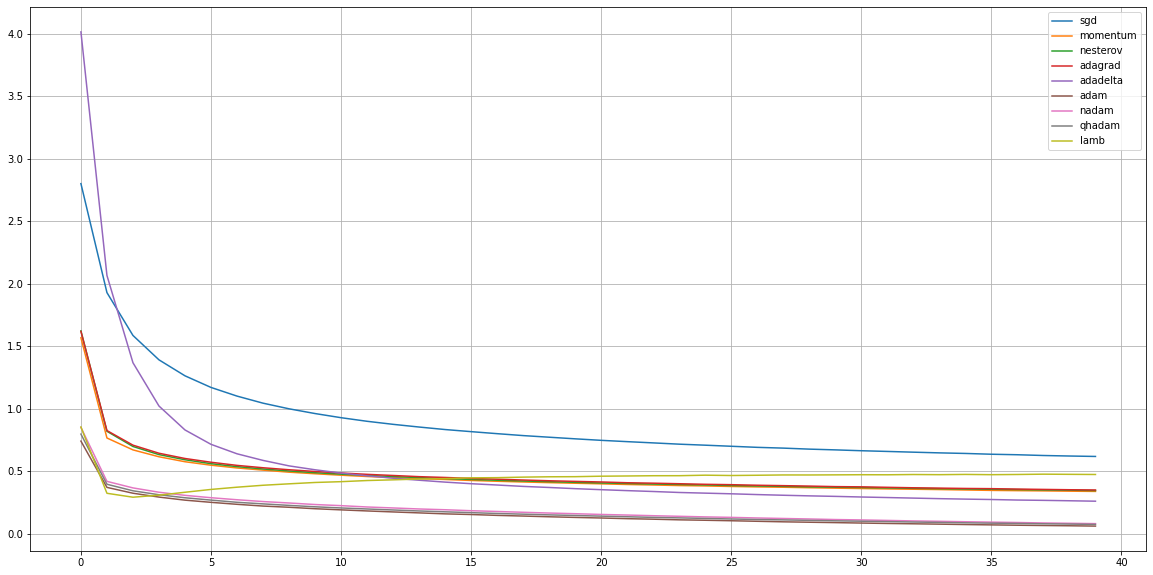

In [63]:
plt.plot(loss_simple_sgd,label='sgd')
plt.plot(loss_momentum_sgd,label='momentum')
plt.plot(loss_nesterov_sgd,label='nesterov')
plt.plot(loss_adagrad,label='adagrad')
plt.plot(loss_adadelta,label='adadelta')
plt.plot(loss_adam,label='adam')
plt.plot(loss_nadam,label='nadam')
plt.plot(loss_ghadam,label='qhadam')
plt.plot(loss_lamb,label='lamb')
plt.legend(loc='best')
plt.grid()
plt.show()